# Encoder-Only Transformer for Binary Classification
**Author:** Jainil  
**Positional Encoding:** Sinusoidal (Vaswani et al., 2017)  
**Formula:** `PE(pos, 2i) = sin(pos / 10000^(2i/d_model))`, `PE(pos, 2i+1) = cos(...)`  
**Properties:** No learnable params | Generalizes to unseen lengths | Static  
**Dataset:** Spam Email (Kaggle)

In [15]:
# CELL 1: IMPORTS
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

load_dotenv()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
# CELL 2: CONFIG
class Config:
    # Data
    dataset_name = "jackksoncsie/spam-email-dataset"
    test_size = 0.2
    val_size = 0.1

    # Model
    d_model = 64
    n_heads = 4
    n_layers = 3
    d_ff = 256
    dropout = 0.1
    max_seq_len = 512

    # Training
    batch_size = 64
    learning_rate = 1e-3
    epochs = 20
    weight_decay = 1e-4

    # Reproducibility
    seed = 42

config = Config()

torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

print("Configuration loaded.")

Configuration loaded.


In [17]:
# CELL 3: LOADING DATASET USING KAGGLE API
import kagglehub

os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME', '')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY', '')

print("Downloading dataset...")
path = kagglehub.dataset_download(config.dataset_name)
print(f"Dataset downloaded to: {path}")

data_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"Available files: {data_files}")

df = pd.read_csv(os.path.join(path, data_files[0]))
print(f"Dataset shape: {df.shape}")
df.head()

Dataset downloaded to: C:\Users\jaini\.cache\kagglehub\datasets\jackksoncsie\spam-email-dataset\versions\1
Available files: ['emails.csv']
Dataset shape: (5728, 2)


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [18]:
# CELL 4: MINIMAL FEATURE ENGINEERING + DATALOADER
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

target_col = 'income' if 'income' in df.columns else df.columns[-1]
print(f"Target column: {target_col}")

y = (df[target_col].astype(str).str.contains('>50K|1')).astype(int).values

X = df.drop(columns=[target_col])

for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.factorize(X[col])[0]

X = X.values.astype(np.float32)
X = np.nan_to_num(X, nan=0.0)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=config.test_size, random_state=config.seed, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=config.val_size, random_state=config.seed, stratify=y_temp
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

config.input_dim = X_train.shape[1]
print(f"Input dimension: {config.input_dim}")

train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)
test_dataset = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Target column: spam
Input dimension: 1
Train: 4123, Val: 459, Test: 1146


In [19]:
# CELL 5: POSITIONAL ENCODING WITH SIN/COS
class SinusoidalPositionalEncoding(nn.Module):
    """
    Positional encoding using sine and cosine functions.
    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_seq_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

pe = SinusoidalPositionalEncoding(d_model=config.d_model)
test_input = torch.zeros(2, 10, config.d_model)
output = pe(test_input)
print(f"Positional Encoding output shape: {output.shape}")

Positional Encoding output shape: torch.Size([2, 10, 64])


In [20]:
# CELL 6: TRANSFORMER BLOCK (ENCODER ONLY)
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )

        return self.W_o(attn_output)


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x


class TransformerEncoder(nn.Module):
    """Encoder-only Transformer for binary classification."""

    def __init__(self, input_dim, d_model, n_heads, n_layers, d_ff,
                 max_seq_len=512, dropout=0.1):
        super().__init__()

        self.input_projection = nn.Linear(input_dim, d_model)

        self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_seq_len, dropout)

        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.input_projection(x)
        x = self.pos_encoding(x)

        for block in self.encoder_blocks:
            x = block(x)

        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits.squeeze(-1)


model = TransformerEncoder(
    input_dim=config.input_dim,
    d_model=config.d_model,
    n_heads=config.n_heads,
    n_layers=config.n_layers,
    d_ff=config.d_ff,
    max_seq_len=config.max_seq_len,
    dropout=config.dropout
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(model)

Total parameters: 152,193
Trainable parameters: 152,193
TransformerEncoder(
  (input_projection): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoding): SinusoidalPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_blocks): ModuleList(
    (0-2): 3 x TransformerEncoderBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,

In [21]:
# CELL 7: LOSS - BINARY CROSS ENTROPY
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.epochs, eta_min=1e-6
)

print(f"Loss function: {criterion}")
print(f"Optimizer: AdamW with lr={config.learning_rate}")
print(f"Scheduler: CosineAnnealingLR")

Loss function: BCEWithLogitsLoss()
Optimizer: AdamW with lr=0.001
Scheduler: CosineAnnealingLR


In [22]:
# CELL 8: TRAINING LOOP
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in tqdm(loader, desc="Training", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    return total_loss / total, correct / total


history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
best_model_state = None

print("Starting training...\n")
for epoch in range(config.epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    print(f"Epoch {epoch+1:02d}/{config.epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights.")

Starting training...



Epoch 01/20 | Train Loss: 0.1589 | Train Acc: 0.9500 | Val Loss: 0.0303 | Val Acc: 0.9891


Epoch 02/20 | Train Loss: 0.0494 | Train Acc: 0.9828 | Val Loss: 0.0129 | Val Acc: 0.9978


Epoch 03/20 | Train Loss: 0.0385 | Train Acc: 0.9845 | Val Loss: 0.0085 | Val Acc: 0.9978


Epoch 04/20 | Train Loss: 0.0273 | Train Acc: 0.9901 | Val Loss: 0.0081 | Val Acc: 0.9978


Epoch 05/20 | Train Loss: 0.0301 | Train Acc: 0.9869 | Val Loss: 0.0116 | Val Acc: 0.9978


Epoch 06/20 | Train Loss: 0.0259 | Train Acc: 0.9901 | Val Loss: 0.0037 | Val Acc: 1.0000


Epoch 07/20 | Train Loss: 0.0339 | Train Acc: 0.9879 | Val Loss: 0.0045 | Val Acc: 1.0000


Epoch 08/20 | Train Loss: 0.0221 | Train Acc: 0.9922 | Val Loss: 0.0080 | Val Acc: 0.9978


Epoch 09/20 | Train Loss: 0.0237 | Train Acc: 0.9888 | Val Loss: 0.0136 | Val Acc: 0.9956


Epoch 10/20 | Train Loss: 0.0214 | Train Acc: 0.9913 | Val Loss: 0.0052 | Val Acc: 0.9978


Epoch 11/20 | Train Loss: 0.0216 | Train Acc: 0.9913 | Val Loss: 0.0092 | Val Acc: 0.9978


Epoch 12/20 | Train Loss: 0.0156 | Train Acc: 0.9937 | Val Loss: 0.0089 | Val Acc: 0.9956


Epoch 13/20 | Train Loss: 0.0192 | Train Acc: 0.9935 | Val Loss: 0.0037 | Val Acc: 0.9978


Epoch 14/20 | Train Loss: 0.0177 | Train Acc: 0.9920 | Val Loss: 0.0043 | Val Acc: 0.9978


Epoch 15/20 | Train Loss: 0.0112 | Train Acc: 0.9944 | Val Loss: 0.0038 | Val Acc: 0.9978


Epoch 16/20 | Train Loss: 0.0103 | Train Acc: 0.9949 | Val Loss: 0.0036 | Val Acc: 0.9978


Epoch 17/20 | Train Loss: 0.0143 | Train Acc: 0.9954 | Val Loss: 0.0032 | Val Acc: 0.9978


Epoch 18/20 | Train Loss: 0.0114 | Train Acc: 0.9951 | Val Loss: 0.0029 | Val Acc: 1.0000


Epoch 19/20 | Train Loss: 0.0117 | Train Acc: 0.9944 | Val Loss: 0.0033 | Val Acc: 0.9978


Epoch 20/20 | Train Loss: 0.0144 | Train Acc: 0.9954 | Val Loss: 0.0032 | Val Acc: 0.9978

Best validation accuracy: 1.0000
Loaded best model weights.


In [23]:
# CELL 9: EVALUATE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

val_preds, val_probs, val_labels = evaluate_model(model, val_loader, device)

print("=" * 50)
print("VALIDATION SET EVALUATION")
print("=" * 50)
print(f"\nAccuracy:  {accuracy_score(val_labels, val_preds):.4f}")
print(f"Precision: {precision_score(val_labels, val_preds):.4f}")
print(f"Recall:    {recall_score(val_labels, val_preds):.4f}")
print(f"F1 Score:  {f1_score(val_labels, val_preds):.4f}")
print(f"ROC-AUC:   {roc_auc_score(val_labels, val_probs):.4f}")

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['Class 0', 'Class 1']))

print("\nConfusion Matrix:")
cm = confusion_matrix(val_labels, val_preds)
print(cm)

VALIDATION SET EVALUATION

Accuracy:  0.9978
Precision: 1.0000
Recall:    0.9909
F1 Score:  0.9954
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       349
     Class 1       1.00      0.99      1.00       110

    accuracy                           1.00       459
   macro avg       1.00      1.00      1.00       459
weighted avg       1.00      1.00      1.00       459


Confusion Matrix:
[[349   0]
 [  1 109]]


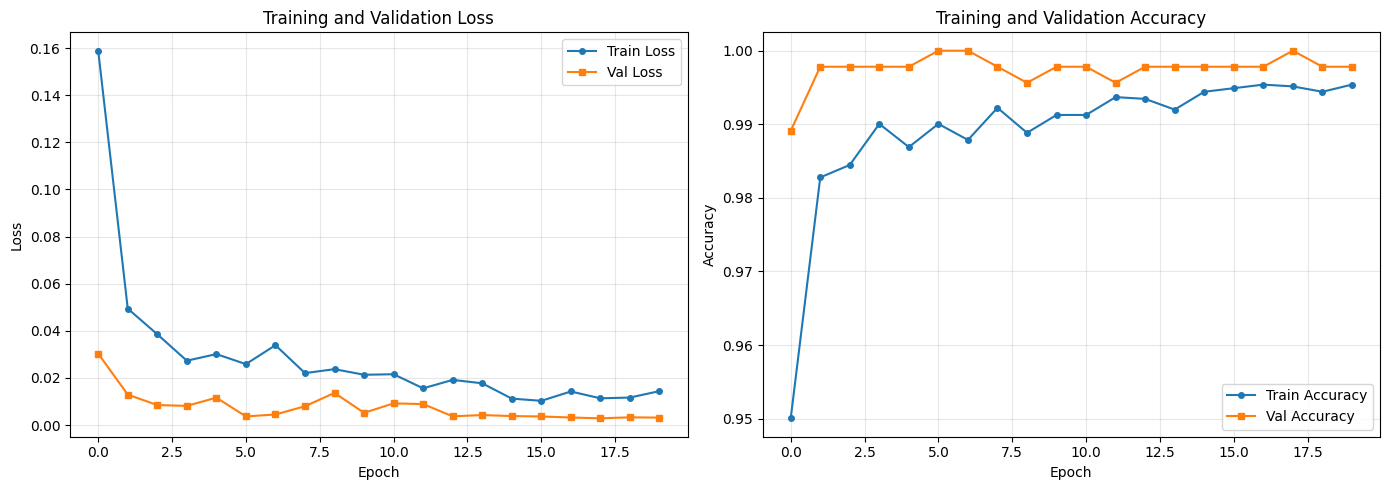

Training curves saved to 'training_curves.png'


In [24]:
# CELL 10: PLOT (LOSS CURVE AND ACCURACY CURVE)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=4)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', markersize=4)
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to 'training_curves.png'")

TEST SET EVALUATION (FINAL RESULTS)

Accuracy:  0.9983
Precision: 1.0000
Recall:    0.9927
F1 Score:  0.9963
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       872
     Class 1       1.00      0.99      1.00       274

    accuracy                           1.00      1146
   macro avg       1.00      1.00      1.00      1146
weighted avg       1.00      1.00      1.00      1146


Confusion Matrix:
[[872   0]
 [  2 272]]


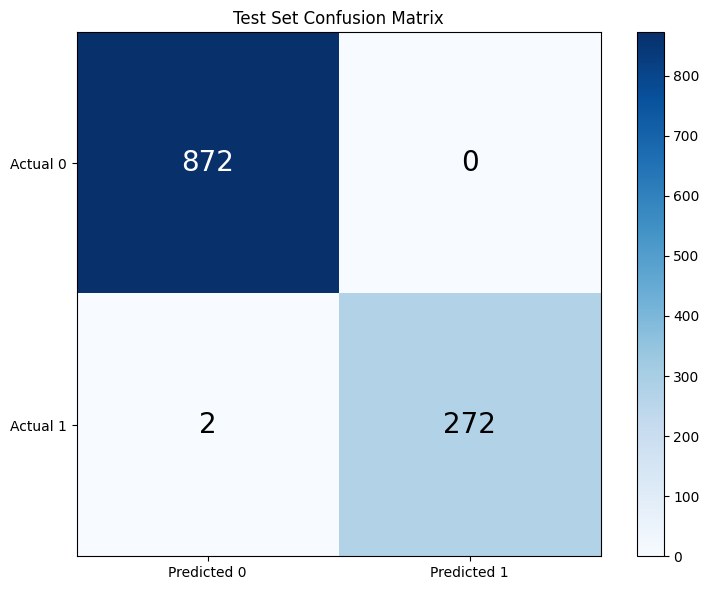


Confusion matrix saved to 'confusion_matrix.png'

Model saved to 'encoder_transformer_model.pt'


In [25]:
# CELL 11: TEST
test_preds, test_probs, test_labels = evaluate_model(model, test_loader, device)

print("=" * 50)
print("TEST SET EVALUATION (FINAL RESULTS)")
print("=" * 50)

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_roc_auc = roc_auc_score(test_labels, test_probs)

print(f"\nAccuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1 Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Class 0', 'Class 1']))

print("\nConfusion Matrix:")
cm_test = confusion_matrix(test_labels, test_preds)
print(cm_test)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_test, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
ax.set_yticklabels(['Actual 0', 'Actual 1'])
ax.set_title('Test Set Confusion Matrix')

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm_test[i, j], ha='center', va='center',
                       color='white' if cm_test[i, j] > cm_test.max()/2 else 'black',
                       fontsize=20)

plt.colorbar(im)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to 'confusion_matrix.png'")

torch.save({
    'model_state_dict': model.state_dict(),
    'config': vars(config),
    'test_metrics': {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    }
}, 'encoder_transformer_model.pt')

print("\nModel saved to 'encoder_transformer_model.pt'")